## Notebook for testing baseline sklearn distributions / classifiers

#### Data and Classes

    X: ndarray (n_samples, n_features)   SHOULD BE 2D
    y: ndarray (n_samples, )
        y is either integers (unnamed classes) or strings (named classes) classes_ holds the class names, it is either inferred from training data or can be set
    
#### Methods

    .fit(X,y)               train from examples   
    .predict_proba(X)       get probabilities of feature vectors   
    .predict_log_proba(X)   get log probabilities of feature vectors   
    .predict(X)             get predicted classes from X   

#### Attributes
    classes_      class names   
    class_count_  class count from training data   
    class_prior_  class prior from training   

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB
import matplotlib.pyplot as plt
import seaborn as sns
cmap = sns.light_palette("caramel",50,input="xkcd")

### Gaussian Distributions
#### 1. Training
#### 2. Evaluation on independent Test Data

In [19]:
class GausClf(GaussianNB):
    def validate_(self):
        """ checks that both sigma_ / var_ are in the model """
        if (not hasattr(self,'variance_')) and (hasattr(self,'sigma_')) :
            self.variance_ = np.square(self.sigma_)        
    def print_model(self):
        self.validate_()
        print('Means')
        print(self.theta_)
        print('Std Dev')
        print(self.sigma_)    
        #print('Variance')
        #print(self.variance_)        

In [34]:
# create some data
#
X, y = load_iris(return_X_y=True)
gClf1 = GausClf()
gClf1.classes_ = np.array(['S0','S1','S2'])
y = gClf1.classes_[y]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# sort train and test to make them look sequential
indx = np.argsort(y_train)
y_train = y_train[indx]
X_train = X_train[indx]
indx = np.argsort(y_test)
y_test = y_test[indx]
X_test = X_test[indx]
# make also a noisy test set
X_noisy = X_test + np.random.normal(loc=0.,scale=.75,size=X_test.shape)

# train a Gaussian model from the training data
gClf1.fit(X_train, y_train)
gClf1.print_model()

Means
[[4.97586207 3.35862069 1.44827586 0.23448276]
 [5.935      2.71       4.185      1.3       ]
 [6.77692308 3.09230769 5.73461538 2.10769231]]
Std Dev
[[0.10321047 0.13208086 0.01629013 0.00846612]
 [0.256275   0.0829     0.255275   0.046     ]
 [0.38869823 0.10147929 0.31303255 0.04763314]]


### Sample Likelihoods per Class

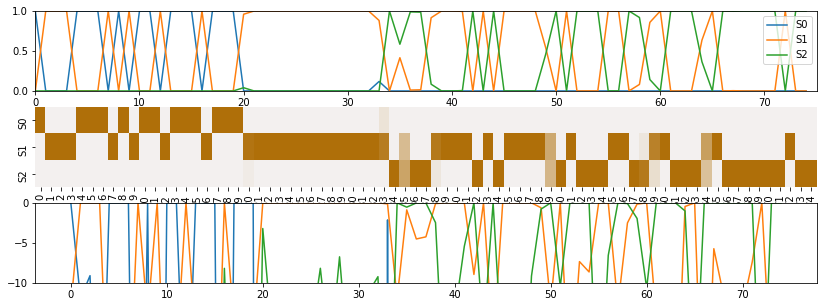

In [35]:
probs=gClf1.predict_proba(X_noisy)
log_probs=gClf1.predict_log_proba(X_noisy)
f,ax=plt.subplots(3,figsize=(14,5))
ax[0].plot(probs)
ax[0].set_xlim([0.,probs.shape[0]])
ax[0].set_ylim([0,1.])
ax[0].legend(gClf1.classes_)
sns.heatmap(probs.T,ax=ax[1],vmax=1,vmin=0.0,yticklabels=gClf1.classes_,
            cmap=cmap,cbar=False, linewidth=0, linecolor='k')
ax[2].plot(log_probs)
ax[2].set_ylim([-10,0.]);

### Classification

In [36]:
y_pred = gClf1.predict(X_test)
print("Test Set: Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
y_pred = gClf1.predict(X_noisy)
print("Noisy Set: Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

Test Set: Number of mislabeled points out of a total 75 points : 4
Noisy Set: Number of mislabeled points out of a total 75 points : 23


### HMM Recognition